## Env setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# For emptying trash after each run
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
drive_service.files().emptyTrash().execute()
!pwd
!nvidia-smi

/content
Wed Jan 17 19:50:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------

## Imports

In [3]:
folder_name = "/content/drive/MyDrive/persuasion_technique_detection/" #"/home/nlp-lab-ws23/nlp_praktikum/persuasion_technique_detection/"

In [4]:
!pip install transformers datasets wandb evaluate accelerate -qU sklearn_hierarchical_classification sentencepiece

In [5]:
import gc
import re
import json
import numpy as np
import pandas as pd
import random
import torch
import subprocess
import json
import warnings
import shutil
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, ViTFeatureExtractor
from sklearn.metrics import f1_score, accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer,LabelEncoder
from sklearn.model_selection import train_test_split
from datasets import Dataset,load_dataset,DatasetDict,concatenate_datasets
import datasets
import os
from torch.nn.functional import sigmoid
from datasets import concatenate_datasets
from PIL import Image
import torch.nn.functional as F
from transformers import AutoModel, AutoImageProcessor,AutoTokenizer,AutoFeatureExtractor,ViTImageProcessor,ViTConfig, BertConfig,CLIPImageProcessor

In [6]:
import torch
AVAIL_GPUS = 0
if torch.cuda.is_available():
    device = torch.device("cuda")
    AVAIL_GPUS = torch.cuda.device_count()
    print(f'There are {AVAIL_GPUS} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


## Login WandB

In [7]:
import wandb
import os

#wandb.login(relogin=True)
wandb.login()

# setup wandb environment variables
os.environ['WANDB_PROJECT'] = "subtask2b"
os.environ['WANDB_ENTITY'] = "tumnlp"
os.environ["WANDB_LOG_MODEL"]= "end"

wandb: Currently logged in as: gozdeunveer (tumnlp). Use `wandb login --relogin` to force relogin


In [8]:
text_checkpoint = "vinai/bertweet-large"
img_checkpoint= "google/vit-base-patch32-224-in21k"

## Preprocess text input

In [9]:
val_path="data/subtask2b/val.json"
train_path="data/subtask2b/train.json"
test_path="data/subtask2b/dev_unlabeled.json"

with open(folder_name+val_path) as f:
  d = json.load(f)
  val=pd.DataFrame.from_dict(d)
  labels=val["label"]
  num_label=[int(el=="propagandistic") for el in labels]
  val["num_label"]=num_label
  val=val.drop(columns=['label'])
  val_set=val.rename(columns={"num_label": "label"})

with open(folder_name+train_path) as f:
  d = json.load(f)
  train=pd.DataFrame.from_dict(d)
  labels=train["label"]
  num_label=[int(el=="propagandistic") for el in labels]
  train["num_label"]=num_label
  train=train.drop(columns=['label'])
  train_set=train.rename(columns={"num_label": "label"})
  #mask = train_set['image'] == "prop_meme_24871.png"
  #train_set = train_set[~mask]

with open(folder_name+test_path) as f:
  d = json.load(f)
  dev_unlabeled_set=pd.DataFrame.from_dict(d)

label2num={"non_propagandistic":0,"propagandistic":1}
num2label={0:"non_propagandistic",1:"propagandistic"}

print(len(train_set),len(val_set),len(dev_unlabeled_set))


1199 150 300


In [10]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, dataset_type,image_processor):
        super().__init__()
        self.ids=list(dataset["id"])
        self.texts = list(dataset["text"])
        self.image_paths = list(dataset["image"])
        if dataset_type=="train" or dataset_type=="val":
          self.labels = dataset["label"].astype(int).tolist()
        self.image_processor = image_processor
        self.dataset_type=dataset_type

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        if self.dataset_type=="train":
          image_path=folder_name+ "data/subtask2b/subtask2b_images/train/"+ self.image_paths[idx]
        elif self.dataset_type=="val":
          image_path=folder_name+ "data/subtask2b/subtask2b_images/val/"+ self.image_paths[idx]
        else:
          image_path=folder_name+ "data/subtask2b/subtask2b_images/dev/"+ self.image_paths[idx]

        #image_input = self.image_processor(images=Image.open(image_path).convert("RGB"), return_tensors="pt")
        image_input=Image.open(image_path).convert("RGB")
        if self.dataset_type=="train" or self.dataset_type=="val":
          label = torch.tensor(self.labels[idx], dtype=torch.float32)
          return self.ids[idx],self.texts[idx],image_input,label
        else:
          return self.ids[idx],self.texts[idx],image_input

In [11]:
tokenizer = AutoTokenizer.from_pretrained(text_checkpoint)
text_model = AutoModel.from_pretrained(text_checkpoint)

# change image processor for different models
image_processor = ViTImageProcessor.from_pretrained(img_checkpoint)  #'google/vit
#image_processor = CLIPImageProcessor.from_pretrained(img_checkpoint) #"openai/clip
#image_processor = AutoImageProcessor.from_pretrained(img_checkpoint)
image_model = AutoModel.from_pretrained(img_checkpoint)
#image_model.config, text_model.config

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
class TextImageBinaryClassifier(nn.Module):
    def __init__(self, text_model, image_model):
        super(TextImageBinaryClassifier, self).__init__()
        self.text_model = text_model
        self.image_model = image_model

        #image_hidden_size=image_model.config.projection_dim #openai/vit
        image_hidden_size=image_model.config.hidden_size # google/vit
        #image_hidden_size=image_model.config.hidden_sizes[-1] #resnet
        #image_hidden_size=image_model.config.hidden_dim # efficientnet

        self.lin1 = nn.Linear(text_model.config.hidden_size + image_hidden_size,512)
        self.relu=nn.ReLU()
        self.lin2=nn.Linear(512,1)

    def forward(self, text_input, image_input):
        # Text encoding
        text_outputs = self.text_model(**text_input)

        text_embedding = text_outputs.last_hidden_state.mean(dim=1)

        # Image encoding
        try:
          #image_embedding=self.image_model.get_image_features(**image_input) #  "openai/clip

          image_outputs = self.image_model(**image_input)  #'google/vit
          image_embedding = image_outputs.last_hidden_state.mean(dim=1) #'google/vit

          #image_outputs = self.image_model(**image_input) # resnet, efficientnet
          #image_embedding=image_outputs.last_hidden_state # resnet, efficientnet
          #image_embedding = F.adaptive_avg_pool2d(image_embedding, (1, 1)).view(image_embedding.size(0), image_embedding.size(1)) # resnet, efficientnet

        except Exception as e:
          print("error:",str(e))


        # Concatenate text and image embeddings
        combined_embedding = torch.cat((text_embedding, image_embedding), dim=1)


        x = self.lin1(combined_embedding)
        x=self.relu(x)
        logits=self.lin2(x)
        return logits

In [13]:
# Create a custom dataset
train_dataset = CustomDataset(train_set,"train", image_processor)
val_dataset = CustomDataset(val_set,"val", image_processor)
test_dataset = CustomDataset(dev_unlabeled_set,"test", image_processor)

batch_size=2
num_workers=2
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=num_workers,pin_memory=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers,pin_memory=True,drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=num_workers,pin_memory=True)

In [14]:
print("train size:",len(train_set),"val size:",len(val_set),"test size:",len(dev_unlabeled_set))

train size: 1199 val size: 150 test size: 300


### Attention visualization methods
source: https://www.kaggle.com/code/piantic/vision-transformer-vit-visualize-attention-map

In [16]:
import cv2
import matplotlib.pyplot as plt

In [17]:
def get_attention_map(img,image_model,get_mask=False):


    image_input = image_processor(images=img, return_tensors="pt")
    output = image_model(**image_input,output_attentions=True)
    att_mat=output.attentions
    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    if get_mask:
        result = cv2.resize(mask / mask.max(), img.size)
    else:
        mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
        result = (mask * img).astype("uint8")

    return result

def plot_attention_map(original_img, att_map):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map Last Layer')
    _ = ax1.imshow(original_img)
    _ = ax2.imshow(att_map)

### Original dataset

In [ ]:
api = wandb.Api()
model_nodes = {
    "persuasion_or_not":"best_model_vinai_bertweet-large-google_vit-base-patch32-224-in21k-subtask2b-memes_5e-06learningRate:v4"
    }

artifact=api.artifact(model_nodes["persuasion_or_not"])
model_dir=artifact.download()
model_state_dict_path = os.path.join(model_dir, model_nodes["persuasion_or_not"].split(":")[0]+".pth" )
model_state_dict = torch.load(model_state_dict_path,map_location=torch.device('cpu')) #,map_location=torch.device('cpu')
text_model = AutoModel.from_pretrained(text_checkpoint)
image_model = AutoModel.from_pretrained(img_checkpoint)
# Instantiate the custom model
model1 = TextImageBinaryClassifier(text_model, image_model)
model1.load_state_dict(model_state_dict)
#model.cuda()

model1.eval()

### Img1

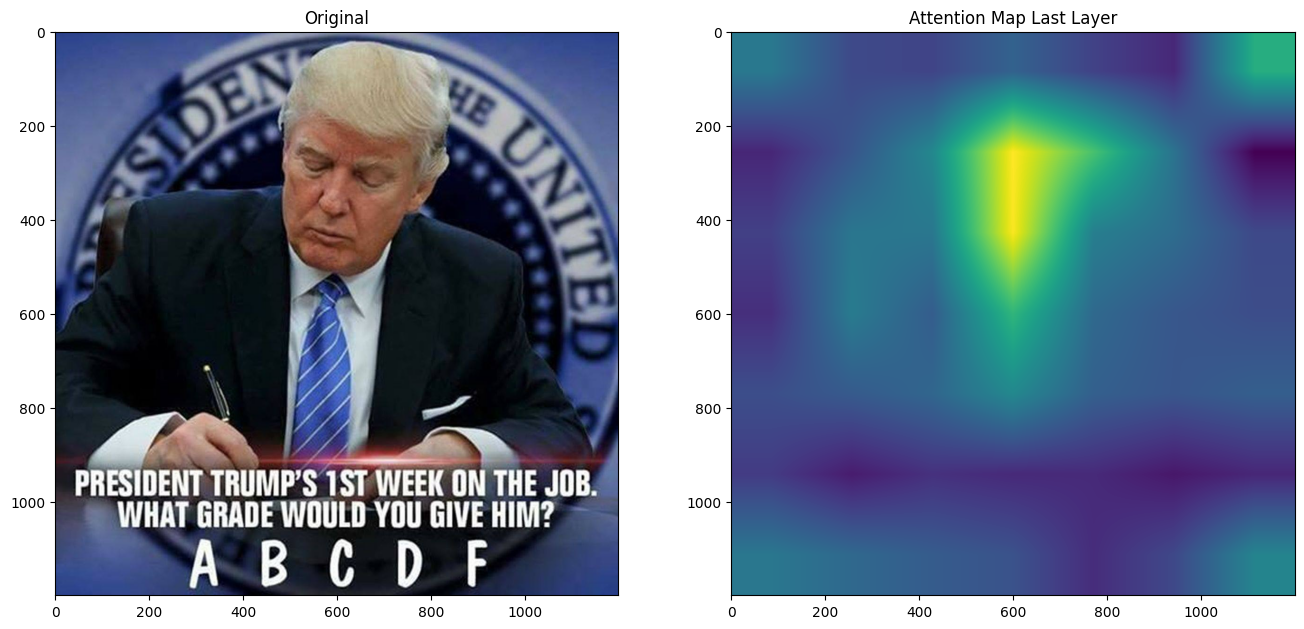

In [30]:
index=0
#image=Image.open("/content/drive/MyDrive/persuasion_technique_detection/data/subtask2b/subtask2b_images/train/prop_meme_10107.png").convert("RGB")
image=Image.open("/content/drive/MyDrive/persuasion_technique_detection/data/subtask2b/subtask2b_images/val/prop_meme_10109.png").convert("RGB")

result2 = get_attention_map(image,model1.image_model,True)
plot_attention_map(image, result2)

### Img 2

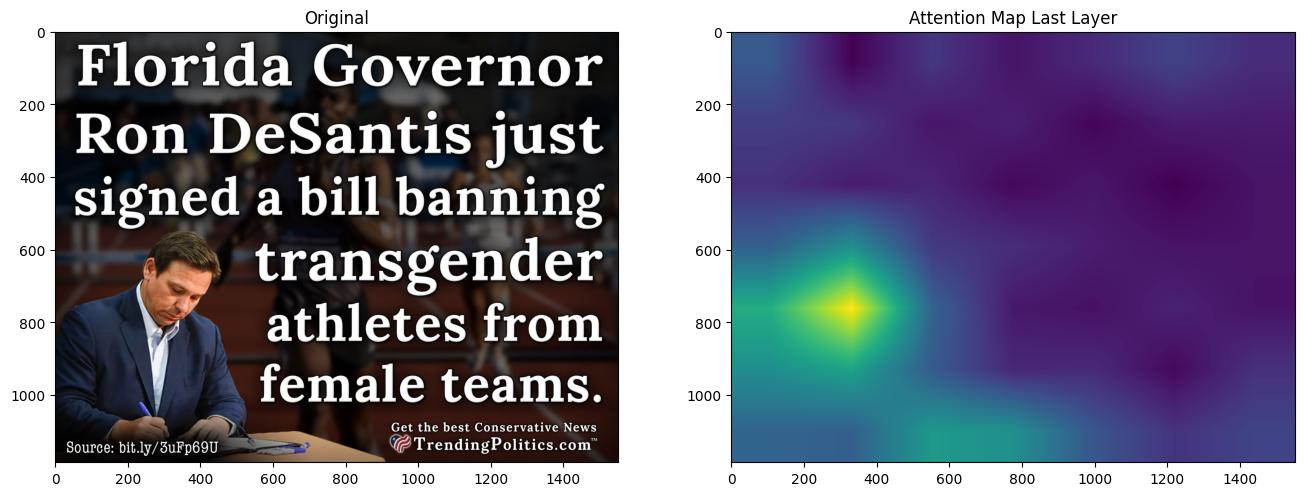

In [38]:
index=0
#image=Image.open("/content/drive/MyDrive/persuasion_technique_detection/data/subtask2b/subtask2b_images/train/prop_meme_10003.png").convert("RGB")
image=Image.open("/content/drive/MyDrive/persuasion_technique_detection/data/subtask2b/subtask2b_images/val/prop_meme_11487.png").convert("RGB")
result2 = get_attention_map(image,model1.image_model,True)
plot_attention_map(image, result2)

### Texts removed dataset

In [ ]:
api = wandb.Api()
model_nodes = {
    "persuasion_or_not":"best_model_vinai_bertweet-large-google_vit-base-patch32-224-in21k-subtask2b-TEXTSREMOVED_5e-06learningRate:v0"
    }

artifact=api.artifact(model_nodes["persuasion_or_not"])
model_dir=artifact.download()
model_state_dict_path = os.path.join(model_dir, model_nodes["persuasion_or_not"].split(":")[0]+".pth" )
model_state_dict = torch.load(model_state_dict_path,map_location=torch.device('cpu')) #,map_location=torch.device('cpu')
text_model = AutoModel.from_pretrained(text_checkpoint)
image_model = AutoModel.from_pretrained(img_checkpoint)
# Instantiate the custom model
model2 = TextImageBinaryClassifier(text_model, image_model)
model2.load_state_dict(model_state_dict)
#model.cuda()

model2.eval()

### Img1

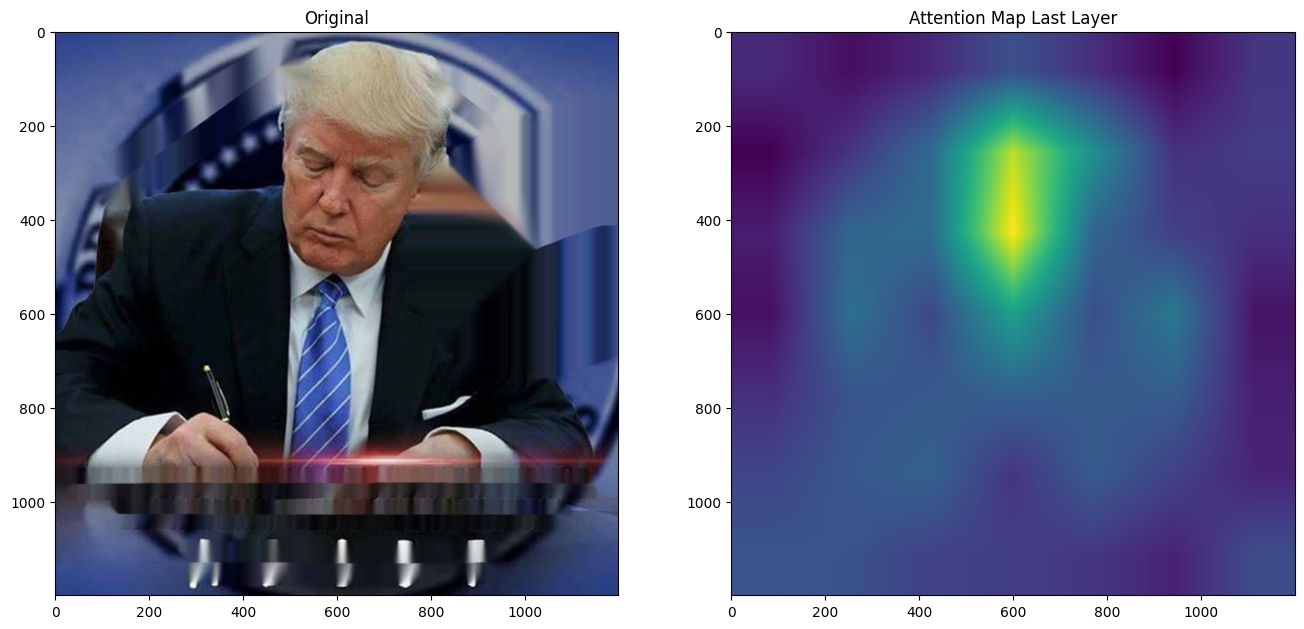

In [31]:
#image=Image.open("/content/prop_meme_6570.png").convert("RGB")
image=Image.open("/content/prop_meme_10109.png").convert("RGB")

result2 = get_attention_map(image,model2.image_model,True)
plot_attention_map(image, result2)

### Img2

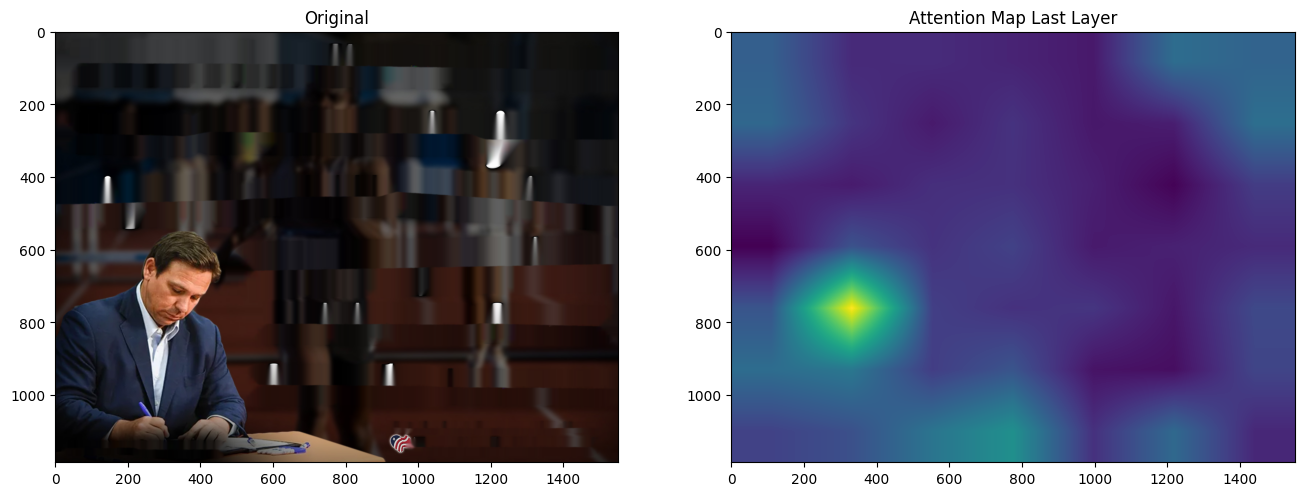

In [40]:
#image=Image.open("/content/prop_meme_10107.png").convert("RGB")
image=Image.open("/content/prop_meme_11487.png").convert("RGB")
result2 = get_attention_map(image,model2.image_model,True)
plot_attention_map(image, result2)